In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

# https://stackoverflow.com/questions/50475635/loading-jsonl-file-as-json-objects
dataset = {
    split: pd.read_json(path_or_buf=f"./refcocog_{split}.jsonl", lines=True)
    for split in ['train', 'test', 'val']
}


In [3]:
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
import os
import dotenv
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dotenv.load_dotenv("/scratch/gsk6me/WORLDMODELS/crl-online-policies/.env")

token = os.environ['HUGGINGFACE_ACCESS_TOKEN']
model_id = "google/paligemma-3b-mix-224"

model = PaliGemmaForConditionalGeneration.from_pretrained("paligemma_refcocog/checkpoint-5000", torch_dtype=torch.bfloat16, token=token, device_map=device)
# model = PaliGemmaForConditionalGeneration.from_pretrained("paligemma_refcocog_lora/checkpoint-10000", torch_dtype=torch.bfloat16, token=token, device_map=device)
# model.load_state_dict("paligemma_refcocog_lora/checkpoint-10000/adapter_model.safetensors")
processor = PaliGemmaProcessor.from_pretrained(model_id, token=token)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


In [4]:
dataset['val'].head()

,image,prefix,suffix
0,/scratch/gsk6me/WORLDMODELS/train2014/COCO_tra...,Describe <loc0456><loc0055><loc0223><loc0295>,Answer: a bush of plant behind middle woman
1,/scratch/gsk6me/WORLDMODELS/train2014/COCO_tra...,Describe <loc0456><loc0055><loc0223><loc0295>,Answer: green plant behind a table visible beh...
2,/scratch/gsk6me/WORLDMODELS/train2014/COCO_tra...,Describe <loc0375><loc0174><loc0259><loc0252>,Answer: black and white dog with pointy ears
3,/scratch/gsk6me/WORLDMODELS/train2014/COCO_tra...,Describe <loc0375><loc0174><loc0259><loc0252>,Answer: the black and white dog nearest the wall
4,/scratch/gsk6me/WORLDMODELS/train2014/COCO_tra...,Describe <loc0630><loc0616><loc0379><loc0268>,Answer: small cow laying down


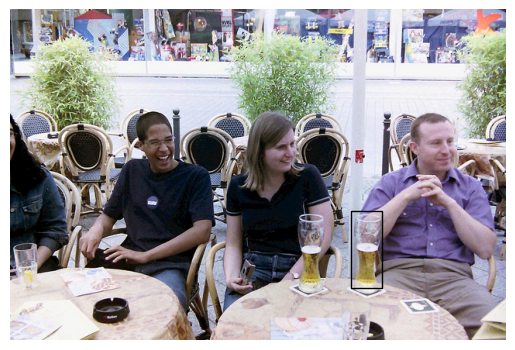

In [24]:
import matplotlib.patches as patches
import PIL.Image

(image_path, prefix, suffix) = dataset['val'].iloc[0]

image = PIL.Image.open(image_path)

x1, y1, x2, y2 = (440, 260, 40, 100)
ax = plt.gca()

ax.imshow(image)
ax.add_patch(patches.Rectangle((x1, y1), (x2), (y2), fill=False))

X1 = 456/1024 * image.width
Y1 = 55/1024 * image.height
X2 = 223/1024 * image.width
Y2 = 295/1024 * image.height

# ax.add_patch(patches.Rectangle((X1, Y1), (X2), (Y2), fill=False))

x1 = int(1024 * x1 / image.width)
y1 = int(1024 * y1 / image.height)
x2 = int(1024 * x2 / image.width)
y2 = int(1024 * y2 / image.height)

prefix_2 = f"Describe <loc{x1:04d}><loc{y1:04d}><loc{x2:04d}><loc{y2:04d}>"

plt.axis('off')
plt.show()


In [25]:
inputs = processor(prefix_2, image.convert("RGB"), return_tensors="pt").to("cuda")
with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=20)

print(processor.decode(output[0], skip_special_tokens=True)[len(prefix_2):])



glass of beer on the table


In [13]:
print(prefix)

Describe <loc0456><loc0055><loc0223><loc0295>
